<a href="https://colab.research.google.com/gist/talhaim11/75d0f7f831b203c65baf616cf36ffba2/generative_deep_learning_-project_tal_haim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The project I chose will be the architecture of Variational autoencoder (VAE)

##**Library Imports**

In [ ]:
import numpy as np #כדי לעשות מניפולציות למערכים
import matplotlib.pyplot as plt # כדי להציג גרפים
from scipy.stats import norm


נשתמש בספריית טנסור פלואו.

In [ ]:
import numpy as np #כדי לעשות מניפולציות למערכים
import matplotlib.pyplot as plt # כדי להציג גרפים
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models,metrics
from keras.models import Sequential, Model

#Types of NN layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,MaxPool2D
from keras.layers import add, LeakyReLU, Activation, ZeroPadding2D,Layer
from keras.layers import Conv2DTranspose, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model 

#Model compiling
from keras import optimizers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras import backend as K

#Data Augmentaion
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow import image

#Preformance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


## **Data Import & Definitions**



In [ ]:
# CIFAR ייבוא דטה סט
(X_train, _), (X_test, _) = datasets.cifar10.load_data()
#חילוק סט האימון ל70 אחוז אימון ו30 אחוז ולידציה
X_train,X_val=train_test_split(X_train,test_size=0.1)



In [ ]:
# MNIST ייבוא דטה סט
(X_train_mnist, _), (X_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()
X_train_mnist,X_val_mnist=train_test_split(X_train_mnist,test_size=0.1)


In [ ]:
#נירמול\סקייל כל הדטה סט
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train_mnist = X_train_mnist.astype('float32')
X_test_mnist = X_test_mnist.astype('float32')
X_val_mnist = X_val_mnist.astype('float32')

# normalize to range 0-1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train_mnist = X_train_mnist / 255.0
X_val_mnist = X_val_mnist / 255.0
X_test_mnist = X_test_mnist / 255.0
#למעשה תמונה מקורית נעה בערכים שלה בין 0 ל 255 מבחינת צבעים והפונקציות איתם נעבוד משתמשות בערכים של 0 עד 1 ולכן נהיה חייבים לעבוד לפי הערכים הללו

In [ ]:
print((X_train.shape))
print((X_val.shape))
print((X_test.shape))

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)


---
importent params
---
---

In [ ]:
input_shape = (32, 32, 3)
hidden_dim = 512
num_features = 784
batch_size = 256
rows = 1 # defining no. of rows in figure
cols = 5 # defining no. of colums in figure
cell_size =1.5 
intermediate_dim = 128  
latent_dim = 2

**Adding Noise**

During the training, each data point is seen by model several times (once per epoch for example) and the model is updated through out the training. So every time a data point is mapped to a different point in the latent space (due to changes of the encoder). But after a while, as the training goes on, these changes get smaller and smaller, until they eventually become negligible. So from this point on, each point is mapped to the same point in the latent space. And the decoder tries to reconstruct the data from that latent representation. But if you add noise to the latent space, it's like instead of passing one data point several times, you are passing a little cluster of several different points. This has two effects:

It makes decoder more robust and lessen the risk of overfitting, because it has to learn that very small changes in the latent space should not change the output drastically.
It helps with the generalization, since you are effectively introducing a little premise which your data space is at least locally convex (meaning that if a point belongs to your distribution, then there exists a neighborhood around it that also belongs to your distribution).

**mathematicly : **

The more mathematical explanation:
The autoencoder is trying to estimate the underlying distribution of your data. And it measures the error and tries to improve the estimated distribution. The problem is that in real world applications, the data space often has a low dimensional support. Meaning that the actual meaningful part of the data can be represented in a few dimensions. Even in very high dimensional problems (like working with images) still the actual structure of the data can be represented in very lower dimensions. For example even though an image may have several thousands of pixels, but we know that not all the possible combinations have meaning. And also there are lots of constraints on the data. Like if the picture is of a skyscraper, then it is probably a tall and straight thing. Or if it is a picture of a dog, then it probably has 4 legs and a face with two eyes, etc.

So the data space is high dimensional, but the support manifold is low dimensional. In such situation, any two distributions are most likely disjoint, meaning they don't collide (namely, the actual data distribution and the estimated distribution). And the error metrics usually can't handle this case very smoothly. The more famous case of this problem is in the GAN architecture that leads to the use of the Wasserstein distance instead of previously-used Jensen-Shannon.

But when you add noise, you are basically stretching the distribution all over the space, and even though this added tail contains no information, it causes the two distributions to not be disjoint. And that helps with the stability of error metrics.

---
autoencoder
---
---

In [ ]:
# הוספת רעש לתמונות כדי לאמן את המודל להתעלם מרעשים רנדומליים ולהצליח לגרום למודל לקחת רק את האלמנטים הדומיננטים
# נייצר רעש במימד השווה למימד התמונות שלנו וכן שיהיה עם התפלגות נורמלית עם ערכים בין 0 ל1
#מאפשרת ליצור ערך גאוסיאני עם קביעת ממוצע, שונות ומימד הערך np.random.normal הפונקציה הזו 
Xtrain_noise = X_train + np.random.normal(0, 0.12, size=X_train.shape) 
Xval_noise = X_val +  np.random.normal(0, 0.12, size=X_val.shape) 
Xtest_noise = X_test +  np.random.normal(0, 0.12, size=X_test.shape)
#כאן נעשה קליפינג לערכים שיהיו בין 0 ל 1 (הקליפינג זו פונקציה שמגבילה ערכים של מערך)
Xtrain_noise = np.clip(Xtrain_noise, 0, 1)
Xval_noise = np.clip(Xval_noise, 0, 1)
Xtest_noise = np.clip(Xtest_noise, 0, 1)  

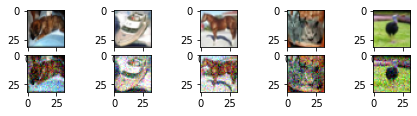

In [ ]:
# מכאן, נדגום כמה תמונות
# כאשר בשורה הראשונה יהיו תמונות מהדטה סט של סיפאר 10 
# וכאשר בשורה השנייה יהיו אותן התמונות, רק עם הוספת הרעש עליהן

f = plt.figure(figsize=(cell_size*cols,cell_size*rows)) #  הגדרת התצוגה- כאשר 12 מסמל את המרווח בין כל תמונה ו4 מסמל את גודל תצוגת התמונה
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(2*rows,cols,(2*i*cols)+(j+1)) # שינוי מיקום תמונה בכל הרצה
        plt.imshow(X_train[i*cols + j]) # הוספת תמונה מתוך התמונות הרגילות של הדטה סט
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # שינוי מתואם של מיקום תמונה 
        plt.imshow(Xtrain_noise[i*cols + j]) # הוספת תמונה מתוך התמונות עם תוספת הרעש של הדטה סט
##plt.axis("off") אם רוצים שהמספרים לא יוצגו ושיהיה יותר אסטטי
#למרות שגם אפשר לשחק עם הסאבפלוט כדי לשנות את מיקומי התמונות 
#כשהתשמשתי רק בפלוט שואו זה היה תמונה על תמונה אז הייתי צריך להשתמש בפונקציה 'פיגור' שמפריד כל תמונה למיקום אחר

---
**building the model**


נתחיל עם בניית האנקודר שמקבל את התמונות עם הרעש ומוציא מהן את האלמנטים החשובים ביותר כדי לצמצם מידע כמה שאפשר

In [ ]:

# Encoder 
inputs = Input(shape=(32,32,3))
Reg_AE = Conv2D(32, 3, activation='relu', padding='same')(inputs)
Reg_AE = BatchNormalization()(Reg_AE)
Reg_AE = MaxPool2D()(Reg_AE)
Reg_AE = Dropout(0.5)(Reg_AE)
skip = Conv2D(32, 3, padding='same')(Reg_AE) # skip connection for decoder
Reg_AE = LeakyReLU()(skip)
Reg_AE = BatchNormalization()(Reg_AE)
Reg_AE = MaxPool2D()(Reg_AE)
Reg_AE = Dropout(0.5)(Reg_AE)
Reg_AE = Conv2D(64, 3, activation='relu', padding='same')(Reg_AE)
Reg_AE = BatchNormalization()(Reg_AE)
encoded = MaxPool2D()(Reg_AE)

# Decoder
Reg_AE = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
Reg_AE = BatchNormalization()(Reg_AE)
Reg_AE = Dropout(0.5)(Reg_AE)
Reg_AE = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(Reg_AE)
Reg_AE = BatchNormalization()(Reg_AE)
Reg_AE = Dropout(0.5)(Reg_AE)
Reg_AE = Conv2DTranspose(32, 3, padding='same')(Reg_AE)
Reg_AE = add([Reg_AE,skip]) # adding skip connection
Reg_AE = LeakyReLU()(Reg_AE)
Reg_AE = BatchNormalization()(Reg_AE)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(Reg_AE)

# Modeling
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])#קומפילציה של המודל לפי 'אדם' עם מהירות למידה של 0.001 
autoencoder.summary()

 #Training
h1 = autoencoder.fit(Reg_AEtrain_noise,Reg_AE_train,epochs=10,batch_size=batch_size,shuffle=True,validation_data=(Reg_AEval_noise, Reg_AE_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
137/137 [==============================] - 4s 24ms/step - loss: 0.6276 - accuracy: 0.4256 - val_loss: 0.6407 - val_accuracy: 0.4752
Epoch 2/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5977 - accuracy: 0.4623 - val_loss: 0.6085 - val_accuracy: 0.5463
Epoch 3/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5896 - accuracy: 0.5948 - val_loss: 0.5931 - val_accuracy: 0.6195
Epoch 4/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5870 - accuracy: 0.6087 - val_loss: 0.5895 - val_accuracy: 0.6278
Epoch 5/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5856 - accuracy: 0.6127 - val_loss: 0.5863 - val_accuracy: 0.6290
Epoch 6/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5845 - accuracy: 0.6149 - val_loss: 0.5835 - val_accuracy: 0.6297
Epoch 7/10
137/137 [==============================] - 3s 19ms/step - loss: 0.5835 - accuracy: 0.6166 - val_loss: 0.5819 - val_accuracy: 0.6315

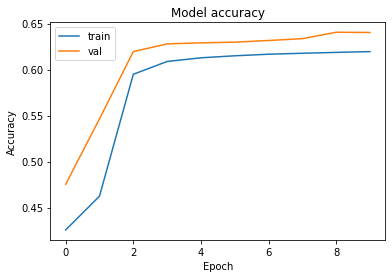

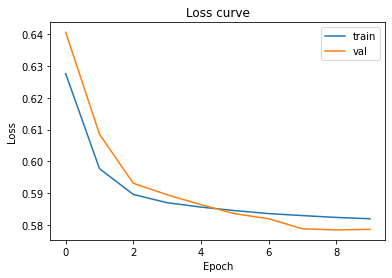

In [ ]:
plt.plot(autoencoder.history.history['accuracy'])#יצירת גרף של דיוק המודל לכל איפוק של סט הטריין
plt.plot(autoencoder.history.history['val_accuracy'])#יצירת גרף של דיוק המודל לכל איפוק של סט הולידציה
plt.title('Model accuracy')#כותרת הגרף
plt.ylabel('Accuracy')#מה מייצג ציר ה Y
plt.xlabel('Epoch')#מה מייצג ציר ה X
plt.legend(['train', 'val'], loc='upper left')#מקרא - למעלה צד שמאל
plt.show()#הצגת הגרף
plt.plot(autoencoder.history.history['loss'])#יצירת גרף של פונקציית המחיר של המודל לכל איפוק של סט הטריין
plt.plot(autoencoder.history.history['val_loss'])#יצירת גרף של פונקציית המחיר של המודל לכל איפוק של סט הטריין
plt.title('Loss curve')#כותרת הגרף
plt.ylabel('Loss')#מה מייצג ציר ה Y
plt.xlabel('Epoch')#מה מייצג ציר ה X
plt.legend(['train', 'val'], loc='upper right')#מקרא -  למעלה צד ימין
plt.show()#הצגת הגרף

נבצע אימון על הדטה סט שלנו עם המודל שהכנו

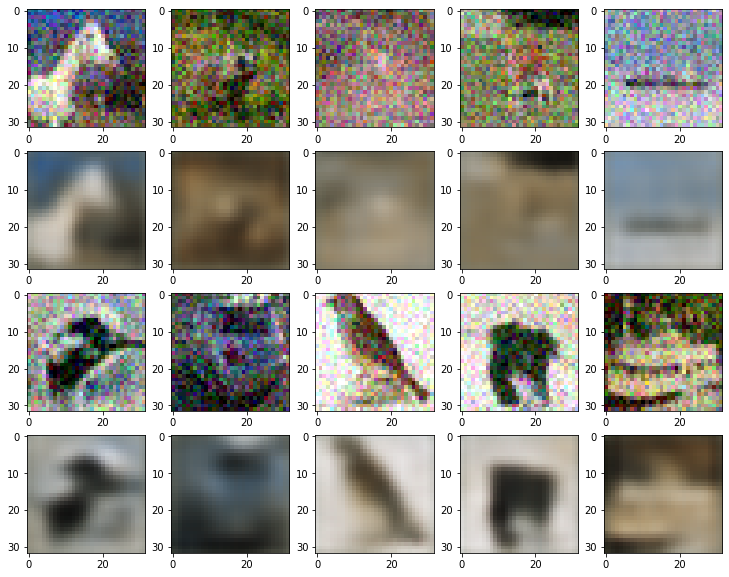

In [ ]:
num_imgs = rows*cols
rand = np.random.randint(1, Xtest_noise.shape[0]-rows*cols) 

Xtest_images = Xtest_noise[rand:rand+num_imgs] # slicing
Xtest_denoised = autoencoder.predict(Xtest_images) # predict

f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(Xtest_images[i*cols + j]) 
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(Xtest_denoised[i*cols + j]) 
       
plt.show()

---
C_VAE
---
---

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

In [ ]:


latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 4096)              12288     
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 16, 16, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 32, 32, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 32, 32, 3)        867 

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


In [ ]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.summary()

ValueError: ignored

In [ ]:
vae.fit(mnist_digits, epochs=30, batch_size=128)

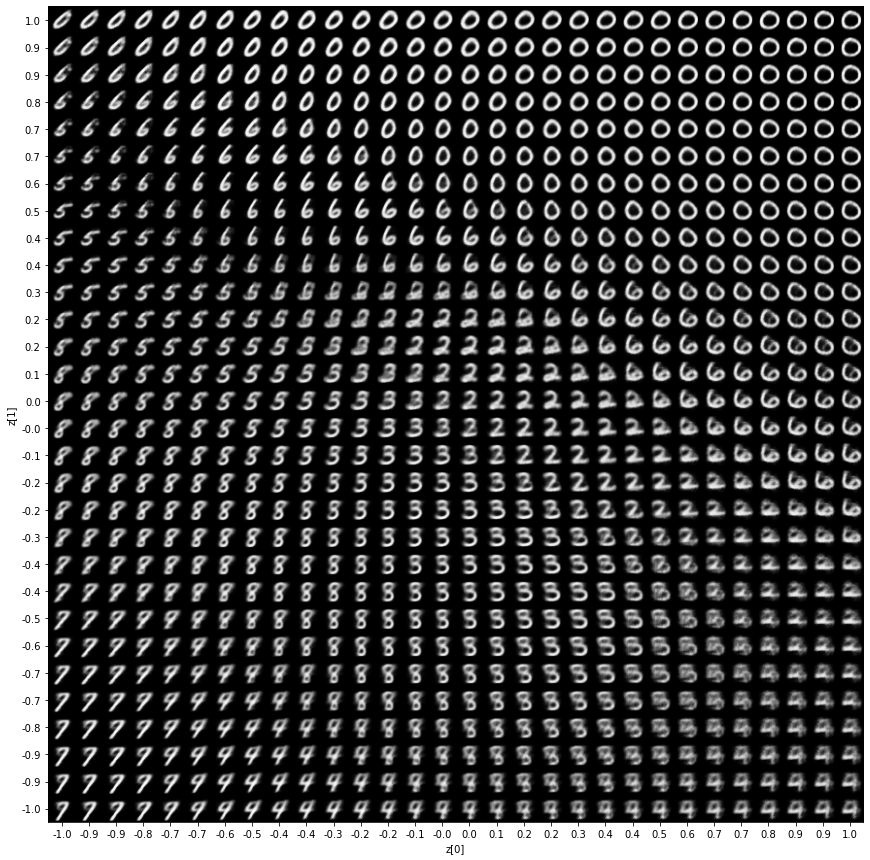

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

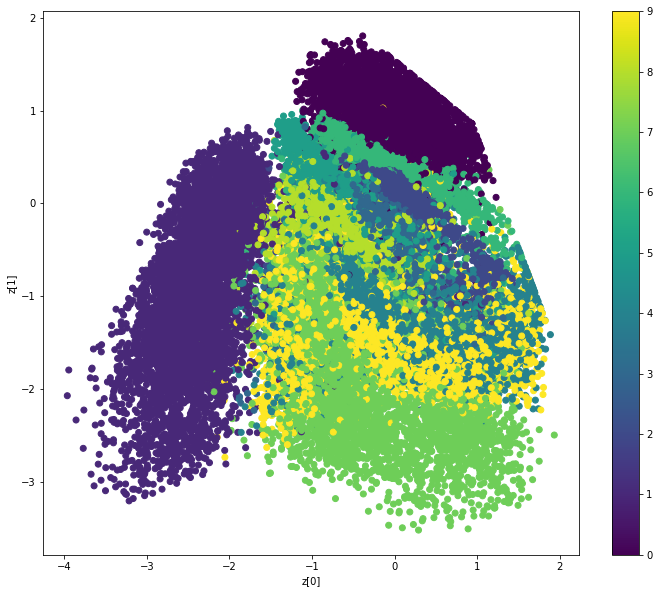

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

---
test 1
---
---

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt # כדי להציג גרפים
from sklearn.model_selection import train_test_split
from keras.models import  Model
from keras import backend as K

In [ ]:
class Sampling(layers.Layer):
    

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
encoder_layers = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
encoder_layers = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(encoder_layers)
encoder_layers = layers.Conv2D(64, 3, padding='same', activation='relu')(encoder_layers)
encoder_layers = layers.Conv2D(64, 3, padding='same', activation='relu')(encoder_layers)
latent_shape = encoder_layers.get_shape().as_list()#דגימה של גודל האובייקט לפני שיטוח וכניסה למערך הדנס
encoder_layers = layers.Flatten()(encoder_layers)
encoder_layers = layers.Dense(16, activation="relu")(encoder_layers)
z_mu = layers.Dense(latent_dim, name="z_mu")(encoder_layers)
z_sigma = layers.Dense(latent_dim, name="z_sigma")(encoder_layers)
z = Sampling()([z_mu, z_sigma])
encoder = keras.Model(encoder_inputs, [z_mu, z_sigma, z], name="encoder")
encoder.summary()


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim))
decoder_layers = layers.Dense(latent_shape[1] * latent_shape[2] * latent_shape[3], activation='relu')(latent_inputs)
decoder_layers = layers.Reshape((latent_shape[1], latent_shape[2], latent_shape[3]))(decoder_layers)
decoder_layers = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(decoder_layers)
latent_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoder_layers)#decoder output
decoder = Model(latent_inputs, latent_outputs, name='decoder')
decoder.summary()

In [ ]:
################

z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([encoder_inputs, z_decoded])

In [ ]:
##################
vae = Model(encoder_inputs, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

In [ ]:
############
vae.fit(x_train, None, epochs = 10, batch_size = 32)

---
test 2
---
---

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt # כדי להציג גרפים
from sklearn.model_selection import train_test_split
from keras.models import  Model
from keras import backend as K
from keras.callbacks import EarlyStopping

In [ ]:
class Sampling(layers.Layer):
    

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
      if isinstance(data, tuple):
        data = data[0]

      z_mean, z_log_var, z = encoder(data)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(
          keras.losses.binary_crossentropy(data, reconstruction)
      )
      reconstruction_loss *= 28 * 28
      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5
      total_loss = reconstruction_loss + kl_loss
      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
encoder_layers = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
encoder_layers = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(encoder_layers)
encoder_layers = layers.Dropout(0.2)(encoder_layers)

latent_shape = encoder_layers.get_shape().as_list()#דגימה של גודל האובייקט לפני שיטוח וכניסה למערך הדנס
encoder_layers = layers.Flatten()(encoder_layers)
encoder_layers = layers.Dense(16, activation="relu")(encoder_layers)
z_mu = layers.Dense(latent_dim, name="z_mu")(encoder_layers)
z_sigma = layers.Dense(latent_dim, name="z_sigma")(encoder_layers)
z = Sampling()([z_mu, z_sigma])
encoder = keras.Model(encoder_inputs, [z_mu, z_sigma, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 64)   0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim))
decoder_layers = layers.Dense(latent_shape[1] * latent_shape[2] * latent_shape[3], activation='relu')(latent_inputs)
decoder_layers = layers.Reshape((latent_shape[1], latent_shape[2], latent_shape[3]))(decoder_layers)
decoder_layers = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(decoder_layers)
decoder_layers = layers.Dropout(0.2)(decoder_layers)
latent_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoder_layers)#decoder output
decoder = Model(latent_inputs, latent_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                 

In [ ]:
(x_train, _), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train,x_val=train_test_split(x_train,test_size=0.1)

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_val = np.expand_dims(x_val, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

es = EarlyStopping(verbose=1,patience=5)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(x_train, epochs=50, batch_size=128,validation_data=(x_val,None),callbacks=[es])

Epoch 1/50
422/422 [==============================] - 22s 22ms/step - loss: 266.0270 - reconstruction_loss: 211.9328 - kl_loss: 4.4805 - val_loss: 198.0583 - val_reconstruction_loss: 196.5911 - val_kl_loss: 1.4672
Epoch 2/50
422/422 [==============================] - 9s 21ms/step - loss: 193.2042 - reconstruction_loss: 187.4733 - kl_loss: 3.6430 - val_loss: 186.1159 - val_reconstruction_loss: 183.9030 - val_kl_loss: 2.2129
Epoch 3/50
422/422 [==============================] - 9s 21ms/step - loss: 178.9846 - reconstruction_loss: 171.0175 - kl_loss: 5.4727 - val_loss: 177.7009 - val_reconstruction_loss: 175.0824 - val_kl_loss: 2.6185
Epoch 4/50
422/422 [==============================] - 9s 22ms/step - loss: 171.8714 - reconstruction_loss: 165.4339 - kl_loss: 5.5111 - val_loss: 173.4641 - val_reconstruction_loss: 170.7399 - val_kl_loss: 2.7242
Epoch 5/50
422/422 [==============================] - 9s 22ms/step - loss: 167.9830 - reconstruction_loss: 161.2521 - kl_loss: 5.7193 - val_loss: 1

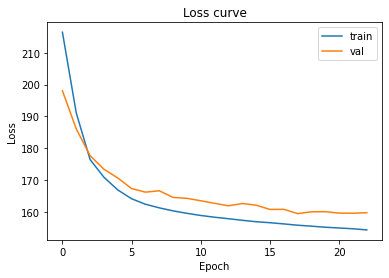

In [ ]:

plt.plot(vae.history.history['loss'])#יצירת גרף של פונקציית המחיר של המודל לכל איפוק של סט הטריין
plt.plot(vae.history.history['val_loss'])#יצירת גרף של פונקציית המחיר של המודל לכל איפוק של סט הטריין
plt.title('Loss curve')#כותרת הגרף
plt.ylabel('Loss')#מה מייצג ציר ה Y
plt.xlabel('Epoch')#מה מייצג ציר ה X
plt.legend(['train', 'val'], loc='upper right')#מקרא -  למעלה צד ימין
plt.show()#הצגת הגרף

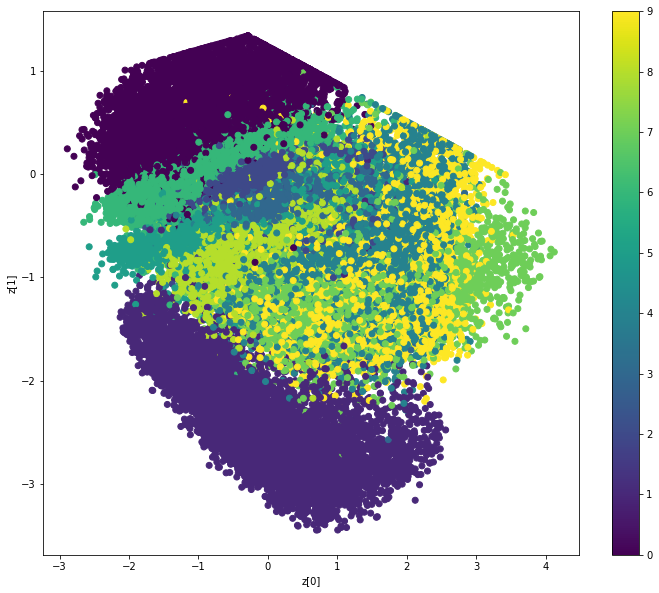

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

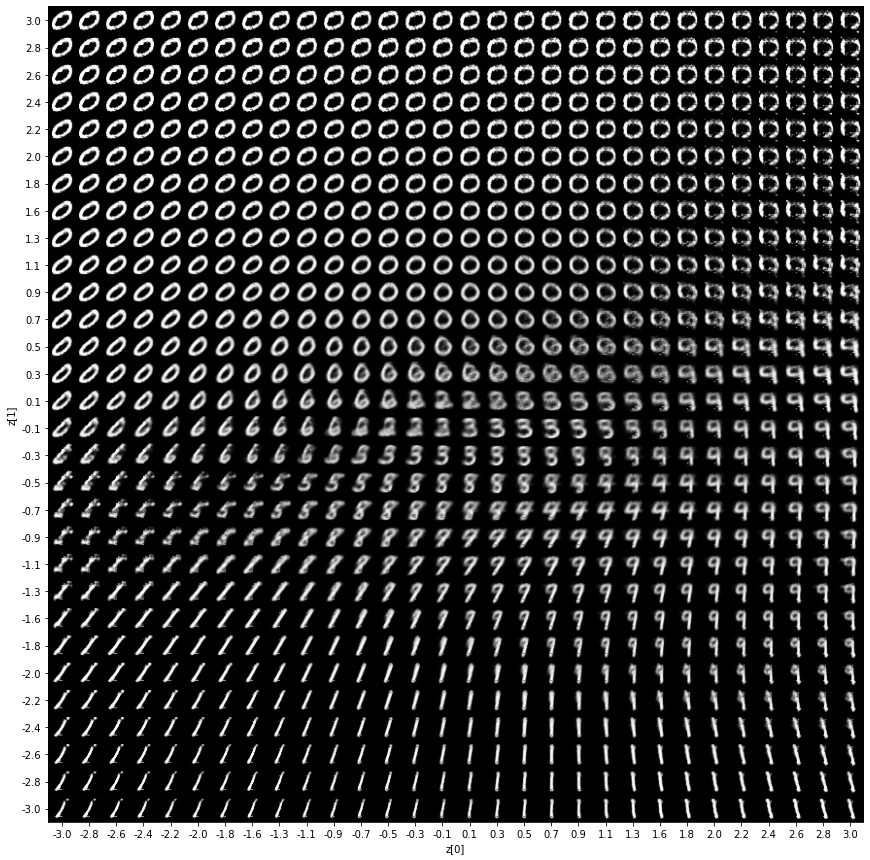

In [ ]:

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 3.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

---
test 3
---
---

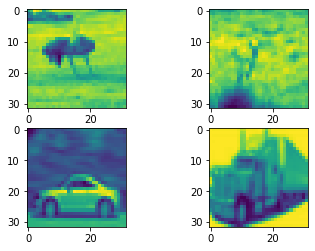

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 64)   36928       ['conv2d_7[0][0]']               
                                                                                            

TypeError: ignored

In [ ]:
#https://youtu.be/YV9D3TWY5Zo
#https://youtu.be/8wrLjnQ7EWQ

"""
VAEs can be used for generative purposes. 
This code demonstrates VAE using MNIST dataset.
Just like regular autoencoder VAE returns an array (image) of same domensions
as input but we can introduce variation by tweaking the latent vector.
"""

from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist, cifar10
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape 
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 3 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
# ========================
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()


# BUILD THE MODEL

# # ================= #############
# # Encoder
#Let us define 4 conv2D, flatten and then dense
# # ================= ############

latent_dim = 2 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)  
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

# Train autoencoder
#####

# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  